# Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re, nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier

In [46]:
nltk.download('stopwords')
nltk.download('wordnet')
lemm = WordNetLemmatizer()
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Getting the data

In [47]:
df_1 = pd.read_json('data/Sarcasm_Headlines_Dataset.json', lines=True)
df_2 = pd.read_json('data/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [48]:
df = pd.concat([df_1, df_2])

In [49]:
df = df.reset_index(drop=True)
df = df.drop(df.columns[0], axis=1) # remove arcticle link column

In [50]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
55323,jews to celebrate rosh hashasha or something,1
55324,internal affairs investigator disappointed con...,1
55325,the most beautiful acceptance speech this week...,0
55326,mars probe destroyed by orbiting spielberg-gat...,1


### check for null

In [51]:
has_null_values = df.isnull().sum()
has_null_values

headline        0
is_sarcastic    0
dtype: int64

# Visualize the Data

### Data count

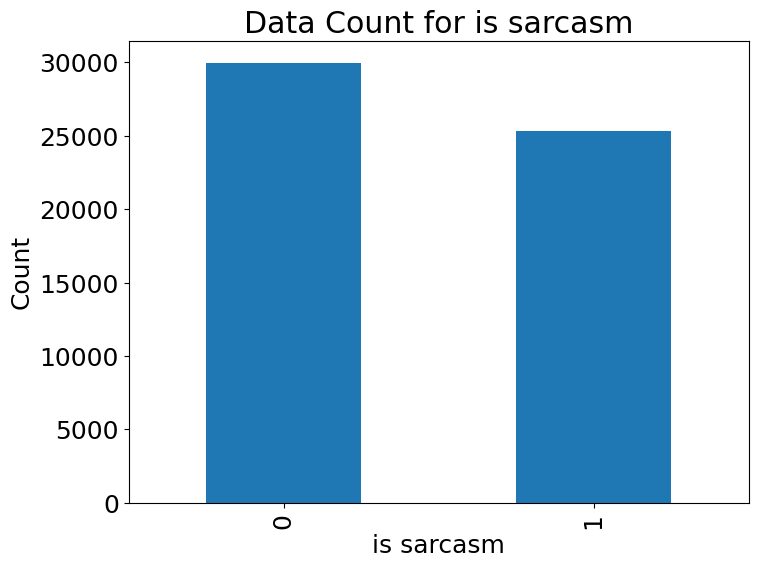

In [52]:
# Get the counts for the last column
counts = df.iloc[:, -1].value_counts()

# Plot the counts
plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.xlabel('is sarcasm')
plt.ylabel('Count')
plt.title('Data Count for is sarcasm')
plt.show()

### Cleaning Data
removing white spaces, uppercase, stop words and lemmatizing the words

In [53]:
stop_words = stopwords.words('english')

def text_cleaning(x):

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)

    return headline


In [54]:
df['clean_headline'] = df['headline'].apply(text_cleaning)

In [55]:
df

,headline,is_sarcastic,clean_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black co...
1,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood b...
2,mom starting to fear son's web series closest ...,1,mom start fear son web series closest thing gr...
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative debt...
4,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wish snape happy birthday magical way
...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,jews celebrate rosh hashasha something
55324,internal affairs investigator disappointed con...,1,internal affairs investigator disappoint consp...
55325,the most beautiful acceptance speech this week...,0,beautiful acceptance speech week come queer ko...
55326,mars probe destroyed by orbiting spielberg-gat...,1,mar probe destroy orbit spielberg gate space p...


### common words for sarcastic vs non_sarcastic

In [56]:
sarcastic = df[df['is_sarcastic']==1]['clean_headline'].tolist()
non_sarcastic = df[df['is_sarcastic']==0]['clean_headline'].tolist()

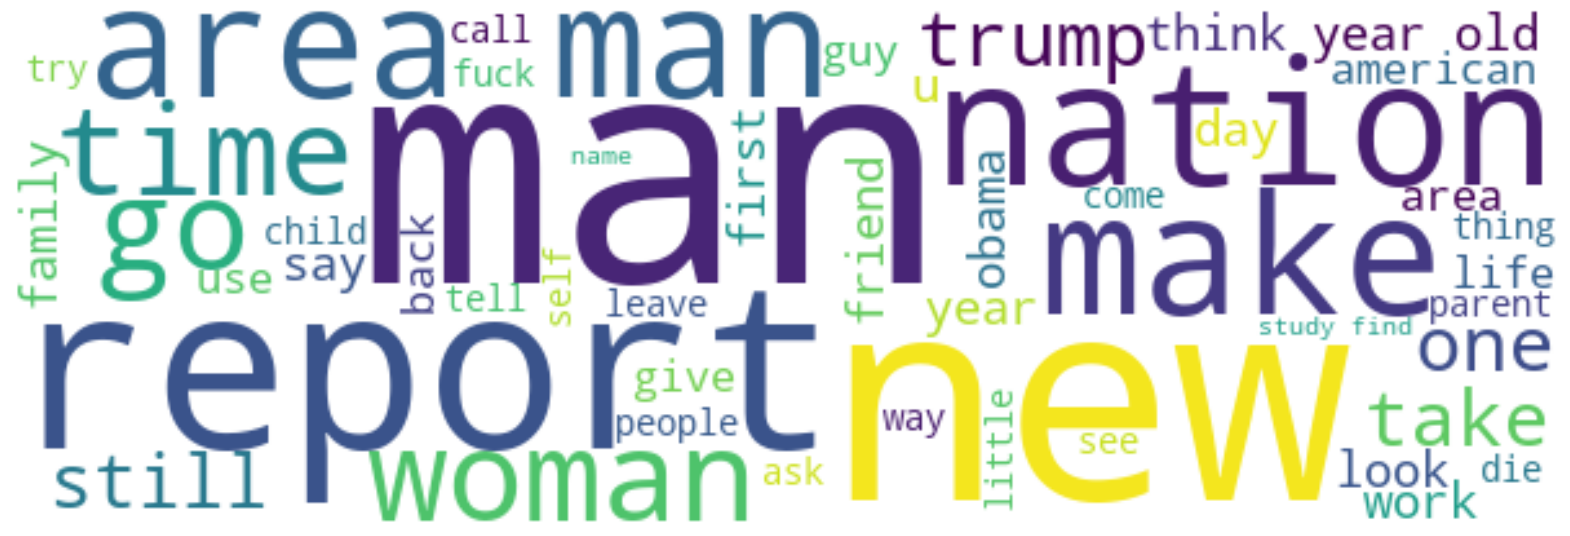

In [57]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

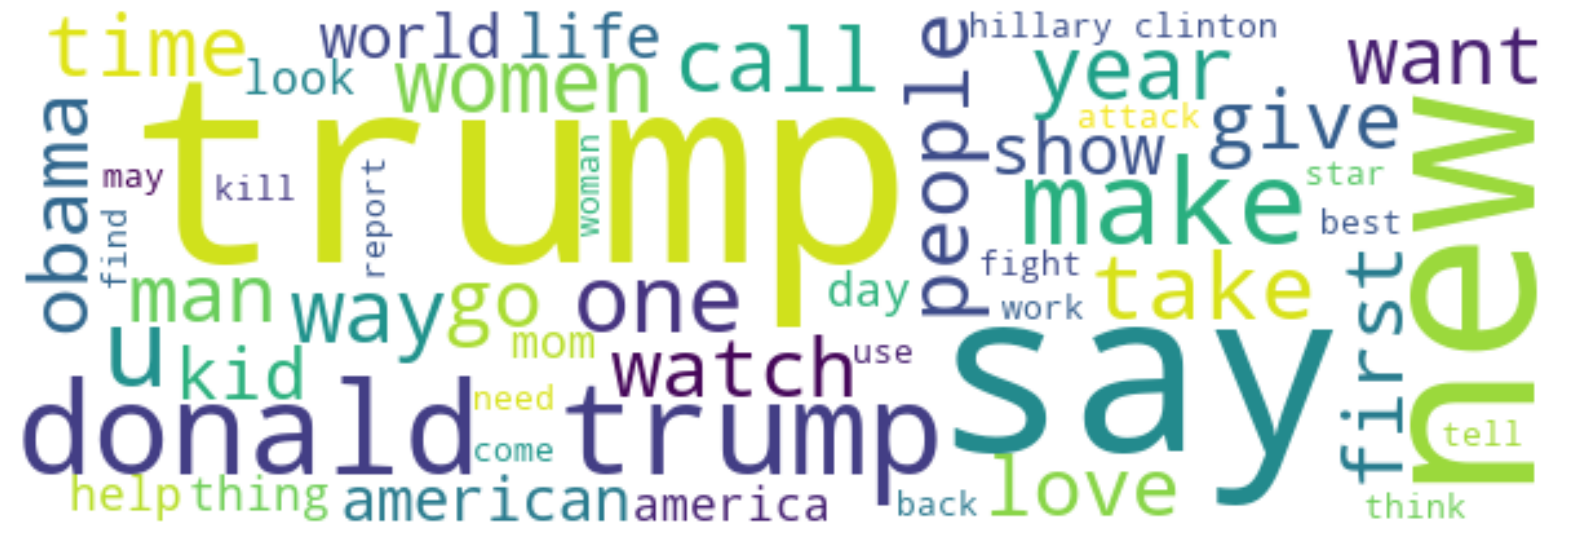

In [58]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(non_sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Adding features

### text length

Text(0.5, 1.0, 'Not Sarcastic text length')

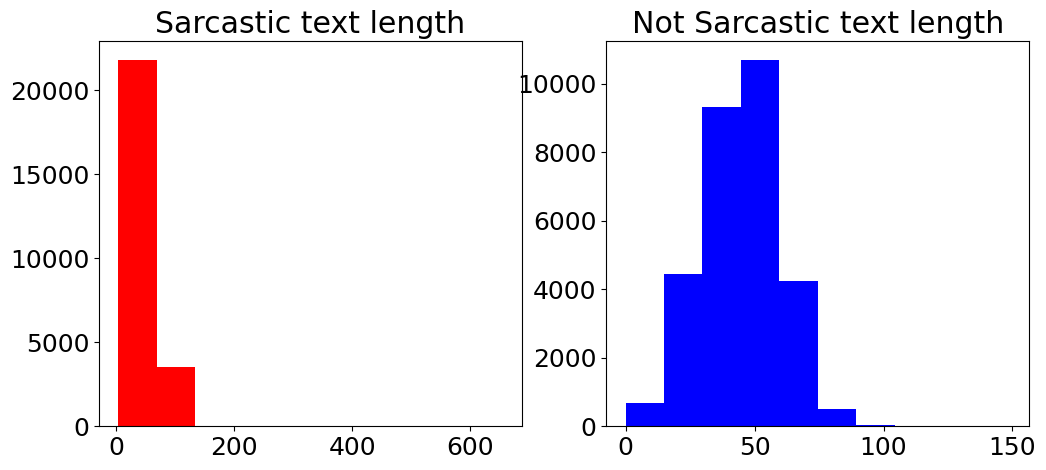

In [59]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.hist([len(x) for x in sarcastic],color='red')
ax1.set_title('Sarcastic text length')
ax2.hist([len(x) for x in non_sarcastic],color='blue')
ax2.set_title('Not Sarcastic text length')

### word count

Text(0.5, 1.0, 'Not Sarcastic text word count')

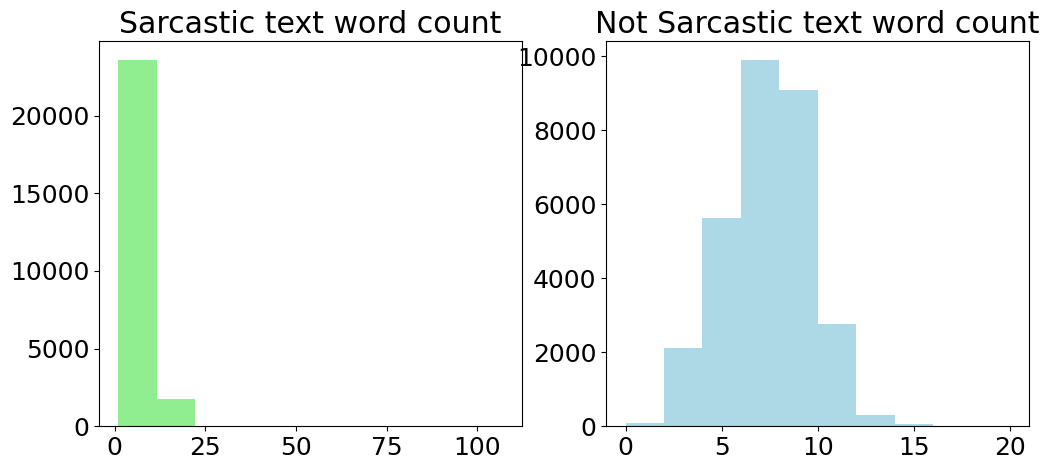

In [60]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
text_len=df[df['is_sarcastic']==1]['clean_headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='lightgreen')
ax1.set_title('Sarcastic text word count')
text_len=df[df['is_sarcastic']==0]['clean_headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='lightblue')
ax2.set_title('Not Sarcastic text word count')

In [61]:
df = df.drop('headline', axis=1)
text_len = [len(x) for x in df['clean_headline']]
word_count = df['clean_headline'].str.split().map(lambda x: len(x))
df['text_len'] = text_len
df['word_count'] = word_count
df

,is_sarcastic,clean_headline,text_len,word_count
0,0,former versace store clerk sue secret black co...,66,10
1,0,roseanne revival catch thorny political mood b...,57,8
2,1,mom start fear son web series closest thing gr...,54,9
3,1,boehner want wife listen come alternative debt...,62,9
4,0,j k rowling wish snape happy birthday magical way,49,9
...,...,...,...,...
55323,1,jews celebrate rosh hashasha something,38,5
55324,1,internal affairs investigator disappoint consp...,62,8
55325,0,beautiful acceptance speech week come queer ko...,50,7
55326,1,mar probe destroy orbit spielberg gate space p...,51,8


# Tokenazation

### drop rows with 0 words

In [62]:
rows_with_zero_words = df[df['word_count'] == 0]
df = df.drop(rows_with_zero_words.index)

### check for max word count

In [63]:
max_word_count = df['word_count'].max()
max_word_count

107

### drop row with 107 word count

In [64]:
max_row = df[df['word_count'] == max_word_count]
df = df.drop(max_row.index)
df.reset_index(inplace=True, drop=True)
df['word_count'].max()

31

### get input and output (text, labels)

In [65]:
text = df["clean_headline"]
labels = df["is_sarcastic"].values
print(labels[:2])
print(text[1])

[0 0]
roseanne revival catch thorny political mood better worse


### tokenizer

In [66]:
tokenize = Tokenizer(oov_token="<oov>")
tokenize.fit_on_texts(text)
word_idx = tokenize.word_index

data_seqence = tokenize.texts_to_sequences(text)
pad_seq = pad_sequences(data_seqence, padding="pre", truncating="pre")

print("The Padding Sequance Shape is  --> ", pad_seq.shape)

The Padding Sequance Shape is  -->  (55325, 31)


In [67]:
input_length = max(len(seq) for seq in data_seqence)

vocabulary_size = len(word_idx) + 1

input_length, vocabulary_size

(31, 21361)

### Put all features together

In [68]:
# Reshape the columns to match the shape of `pad_seq`
word_count = np.array(df['word_count']).reshape(-1, 1)
text_len = np.array(df['text_len']).reshape(-1, 1)

# Concatenate `pad_seq`, `word_count`, and `text_len`
features = np.concatenate((pad_seq, word_count, text_len), axis=1)

# Verify the shape of the resulting features array
print(features.shape)

(55325, 33)


In [69]:
features

array([[   0,    0,    0, ..., 7196,   10,   66],
       [   0,    0,    0, ..., 1004,    8,   57],
       [   0,    0,    0, ..., 8990,    9,   54],
       ...,
       [   0,    0,    0, ..., 1721,    7,   50],
       [   0,    0,    0, ..., 5432,    8,   51],
       [   0,    0,    0, ...,  101,    4,   21]], dtype=int64)

## Store Data in a file

In [71]:
np.save('clean_data/features.npy', features)
np.save('clean_data/labels.npy', labels)

# Spilt Train , Test Data

In [72]:
x_train, x_test_full, y_train, y_test_full = train_test_split(features, labels, train_size=0.6)
x_test, x_cv, y_test, y_cv = train_test_split(x_test_full, y_test_full, train_size=0.5)
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(33195, 33)
(11065, 33)
(11065, 33)


Train model with 1 hidden layer

# Train with keras

# Different parameters using GridSearchCV
### neurons and learning rate

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(neurons):
    # create model
    model = Sequential([
    Embedding(vocabulary_size, neurons[0], input_length=input_length+2),
    GlobalAveragePooling1D(),
    Dense(neurons[1], activation="relu", name="hidden_layer"), 
    Dense(1, activation="sigmoid", name="output_layer")
])
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, epochs=50, batch_size=64, verbose=2)
print("model created")
# define the grid search parameters
neurons = [[20, 10],
           [50, 25],
           [100, 50]]
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(model__neurons=neurons, optimizer__learning_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("%f mean with: %r" % (mean, param))

model created


# Different layers

### Define 3 models

In [103]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocabulary_size, 16, input_length=input_length+2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='relu'), # dense
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid') # dense
])

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocabulary_size, 16, input_length=input_length+2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='relu'), # dense
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),  # dense
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid') # dense
])

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocabulary_size, 16, input_length=input_length+2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='relu'), # dense
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),  # dense
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),  # dense
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid') # dense
])

### Train

In [104]:
models = [model_1, model_2, model_3]
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history_layers = []

for model in models:
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=Adam(0.01),
        metrics=["accuracy"]
    )
    history = model.fit( 
        x_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(x_cv, y_cv),
        verbose=2,
        callbacks=[early_stopping]
    )
    history_layers.append(history)

Epoch 1/50
1038/1038 - 6s - loss: 0.4811 - accuracy: 0.7622 - val_loss: 0.3742 - val_accuracy: 0.8298 - 6s/epoch - 6ms/step
Epoch 2/50
1038/1038 - 5s - loss: 0.2911 - accuracy: 0.8774 - val_loss: 0.3385 - val_accuracy: 0.8531 - 5s/epoch - 5ms/step
Epoch 3/50
1038/1038 - 5s - loss: 0.2171 - accuracy: 0.9131 - val_loss: 0.3563 - val_accuracy: 0.8529 - 5s/epoch - 5ms/step
Epoch 4/50
1038/1038 - 5s - loss: 0.1768 - accuracy: 0.9250 - val_loss: 0.3419 - val_accuracy: 0.8730 - 5s/epoch - 5ms/step
Epoch 5/50
1038/1038 - 5s - loss: 0.1520 - accuracy: 0.9364 - val_loss: 0.4010 - val_accuracy: 0.8678 - 5s/epoch - 5ms/step
Epoch 6/50
1038/1038 - 5s - loss: 0.1351 - accuracy: 0.9411 - val_loss: 0.3711 - val_accuracy: 0.8746 - 5s/epoch - 5ms/step
Epoch 7/50
1038/1038 - 5s - loss: 0.1211 - accuracy: 0.9485 - val_loss: 0.4178 - val_accuracy: 0.8790 - 5s/epoch - 5ms/step
Epoch 8/50
1038/1038 - 5s - loss: 0.1129 - accuracy: 0.9490 - val_loss: 0.4530 - val_accuracy: 0.8789 - 5s/epoch - 5ms/step
Epoch 1/

### History

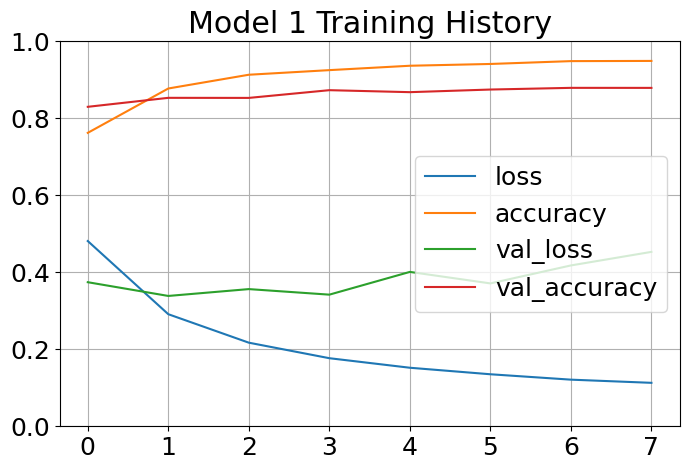

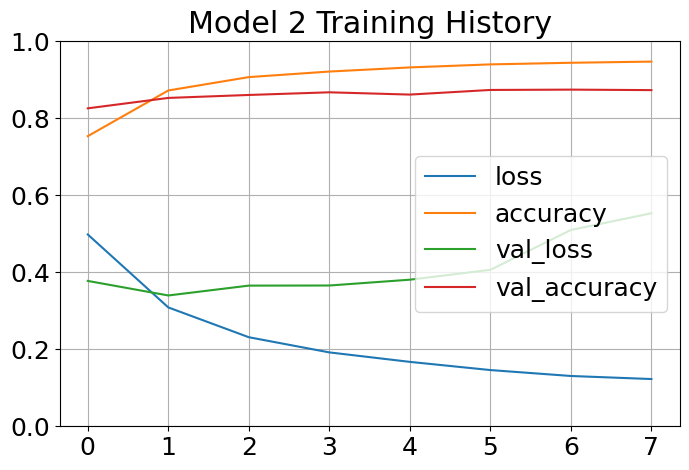

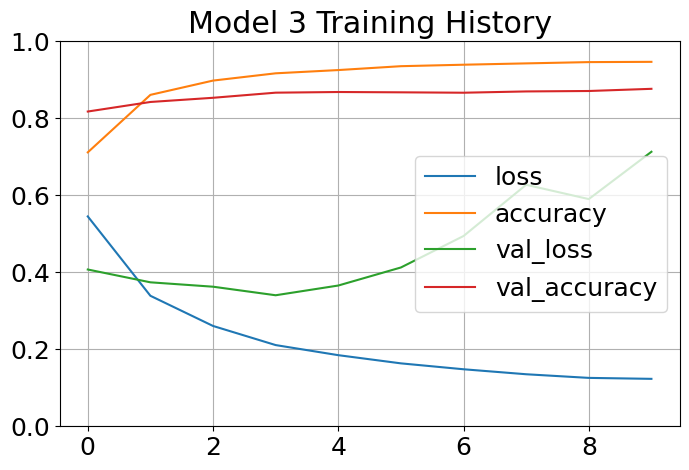

In [105]:
i = 1
for history in history_layers:
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
    plt.title(f'Model {i} Training History')  # Add a title to the plot
    plt.show()
    i += 1


### Test

In [106]:
i = 1
for model in models:
    result = model.evaluate(x_test, y_test)
    print(result)
    print("model_", i)
    print("Test loss: ", result[0])
    print("Test accuracy: ", result[1])
    print()
    i += 1

346/346 [==============================] - 1s 2ms/step - loss: 0.2561 - accuracy: 0.9007
[0.2561269998550415, 0.9006778001785278]
model_ 1
Test loss:  0.2561269998550415
Test accuracy:  0.9006778001785278

346/346 [==============================] - 1s 2ms/step - loss: 0.2563 - accuracy: 0.8985
[0.2562824487686157, 0.8985087871551514]
model_ 2
Test loss:  0.2562824487686157
Test accuracy:  0.8985087871551514

346/346 [==============================] - 1s 2ms/step - loss: 0.2270 - accuracy: 0.9139
[0.22696582973003387, 0.9138725996017456]
model_ 3
Test loss:  0.22696582973003387
Test accuracy:  0.9138725996017456



# Optimizers: Adam vs SGD

### choose model 1, 2 or 3 and train on sgd

In [79]:
model_sgd = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocabulary_size, 16, input_length=input_length+2),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='relu'), # dense
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid') # dense
])

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

model_sgd.compile(loss=BinaryCrossentropy(),
              optimizer="sgd",
              metrics=["accuracy"])

history_sgd = model_sgd.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_cv, y_cv),
                    verbose=2, callbacks=[early_stopping])

Epoch 1/50
1038/1038 - 5s - loss: 0.6935 - accuracy: 0.5318 - val_loss: 0.6828 - val_accuracy: 0.5422 - 5s/epoch - 5ms/step
Epoch 2/50
1038/1038 - 4s - loss: 0.6865 - accuracy: 0.5488 - val_loss: 0.6785 - val_accuracy: 0.5937 - 4s/epoch - 4ms/step
Epoch 3/50
1038/1038 - 4s - loss: 0.6820 - accuracy: 0.5623 - val_loss: 0.6804 - val_accuracy: 0.5900 - 4s/epoch - 4ms/step
Epoch 4/50
1038/1038 - 4s - loss: 0.6788 - accuracy: 0.5677 - val_loss: 0.6736 - val_accuracy: 0.6168 - 4s/epoch - 4ms/step
Epoch 5/50
1038/1038 - 4s - loss: 0.6743 - accuracy: 0.5783 - val_loss: 0.6692 - val_accuracy: 0.6052 - 4s/epoch - 4ms/step
Epoch 6/50
1038/1038 - 4s - loss: 0.6694 - accuracy: 0.5849 - val_loss: 0.6542 - val_accuracy: 0.6553 - 4s/epoch - 4ms/step
Epoch 7/50
1038/1038 - 4s - loss: 0.6629 - accuracy: 0.5992 - val_loss: 0.6409 - val_accuracy: 0.6607 - 4s/epoch - 4ms/step
Epoch 8/50
1038/1038 - 4s - loss: 0.6567 - accuracy: 0.6051 - val_loss: 0.7062 - val_accuracy: 0.5537 - 4s/epoch - 4ms/step
Epoch 9/

### History

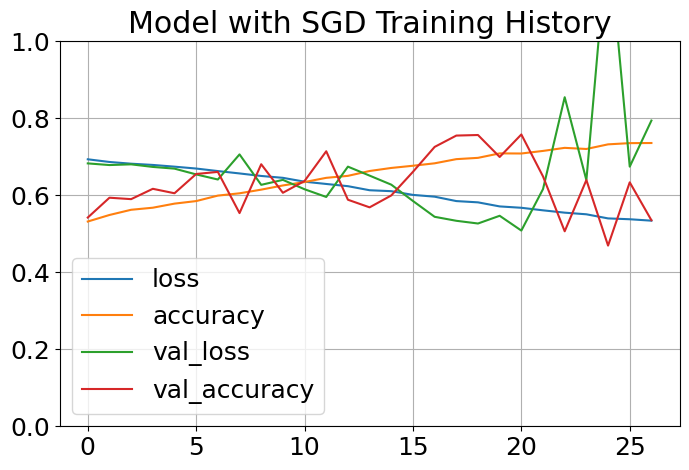

In [82]:
df_history = pd.DataFrame(history_sgd.history)
df_history.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.title(f'Model with SGD Training History')  # Add a title to the plot
plt.show()

# Different Data size

### Split Data

In [100]:
print(features.shape)

# split the data into 3 subsets
x_1, x, y_1, y = train_test_split(features, labels, train_size=0.3)

x_2, x_3, y_2, y_3 = train_test_split(x, y, train_size=0.5)

X = [x_1, x_2, x_3]
Y = [y_1, y_2, y_3]

(55325, 33)


In [107]:
losses = []

# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocabulary_size, 16, input_length=input_length+2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='relu'), # dense
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid') # dense
])

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(0.01), metrics=["accuracy"])

# train the model
for x, y in zip(X, Y):
    x_train, x_cv, y_train, y_cv = train_test_split(features, labels, train_size=0.6)
  
    history = model.fit(x_train, y_train, epochs=20, batch_size=32,
                        validation_data=(x_cv, y_cv), verbose=2)

    losses.append(history.history['loss'])  

Epoch 1/20
1038/1038 - 6s - loss: 0.5432 - accuracy: 0.7131 - val_loss: 0.3865 - val_accuracy: 0.8275 - 6s/epoch - 6ms/step
Epoch 2/20
1038/1038 - 5s - loss: 0.3581 - accuracy: 0.8520 - val_loss: 0.3486 - val_accuracy: 0.8450 - 5s/epoch - 5ms/step
Epoch 3/20
1038/1038 - 5s - loss: 0.2808 - accuracy: 0.8895 - val_loss: 0.3645 - val_accuracy: 0.8582 - 5s/epoch - 5ms/step
Epoch 4/20
1038/1038 - 5s - loss: 0.2374 - accuracy: 0.9083 - val_loss: 0.3643 - val_accuracy: 0.8644 - 5s/epoch - 5ms/step
Epoch 5/20
1038/1038 - 5s - loss: 0.2054 - accuracy: 0.9214 - val_loss: 0.3805 - val_accuracy: 0.8621 - 5s/epoch - 5ms/step
Epoch 6/20
1038/1038 - 5s - loss: 0.1779 - accuracy: 0.9315 - val_loss: 0.3941 - val_accuracy: 0.8718 - 5s/epoch - 5ms/step
Epoch 7/20
1038/1038 - 5s - loss: 0.1622 - accuracy: 0.9366 - val_loss: 0.4059 - val_accuracy: 0.8738 - 5s/epoch - 5ms/step
Epoch 8/20
1038/1038 - 5s - loss: 0.1510 - accuracy: 0.9415 - val_loss: 0.4069 - val_accuracy: 0.8700 - 5s/epoch - 5ms/step
Epoch 9/

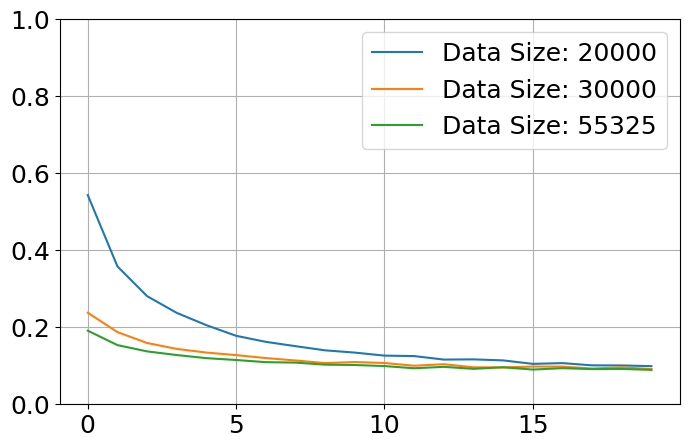

In [108]:
# Plotting loss values for each data size
plt.figure(figsize=(8, 5))
for i, loss in enumerate(losses):
    plt.plot(range(len(loss)), loss, label=f"Data Size: {data_sizes[i+1]}")
plt.grid(True)
plt.ylim(0, 1)
plt.legend()
plt.show()